In [81]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay, DateOffset
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from flask import Flask, request, jsonify
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ticker = 'NG=F'

# Class

In [112]:
class Arima():
    def __init__(self, ticker, forecast_timeframe=252, show=False, options=False):
        # Global Constants
        self.FD = 'First Difference'
        self.SECD ='Second Difference'
        self.SD = 'Seasonal Difference'
        self.SFD = 'Seasonal First Difference'
        self.now = datetime.datetime.now().strftime('%Y-%m-%d')
        
        # Global Variables
        self.ticker = ticker
        self.show = show
        self.options = options 
        self.forecast_timeframe = forecast_timeframe
        
        # Global Dataframe
        self.df, self.time_series = self.setup(ticker)
        self.df, self.adf_fd, self.adf_secd, self.adf_sd, self.adf_sfd = self.differencing(self.df)
        self.df, self.results = self.model(self.df)
        self.forecasted_df = self.forecast(self.df, self.forecast_timeframe)
        
        # TODO Load into Prisma
                
    def setup(self, ticker):
        # Get stock data
        stock = yf.Ticker(ticker).history(period="10y")
        
        # Reset index to index rather than date
        stock = stock.reset_index()
        
        # Create new df with only date and close
        df = stock[['Date', 'Close']]
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
        df.set_index('Date', inplace=True)

        # Create time series
        time_series = df['Close']
            
        return df, time_series
            
    def differencing(self, df):
        # Differencing: first difference, change from one period to the next
        df[self.FD] = df['Close'] - df['Close'].shift(1)
        adf_fd = self.adf_check(self.df[self.FD].dropna(), self.FD)

        # Second
        df[self.SECD] = df[self.FD] - df[self.FD].shift(1)
        adf_secd = self.adf_check(self.df[self.SECD].dropna(), self.SECD)
        
        # Seasonal
        df[self.SD] = df['Close'] - df['Close'].shift(30)
        adf_sd = self.adf_check(self.df[self.SD].dropna(), self.SD)
        
        # Seasonal First Difference
        df[self.SFD] = df[self.FD] - df[self.FD].shift(30)
        adf_sfd = self.adf_check(self.df[self.SFD].dropna(), self.SFD)
        
        return df, adf_fd, adf_secd, adf_sd, adf_sfd
       
    def model(self, df):
        # Need frequency for SARIMA model
        df.index.freq = 'D' # may or may not need
        
        # seasonal arima model
        model = sm.tsa.arima.ARIMA(df['Close'], order=(0, 1, 0), seasonal_order=(0, 1, 0, 365))
        
        # Fit model to see results
        results = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
            
        return df, results
    
    def forecast(self, df, forecast_timeframe):
        # Reset the index of df
        df.reset_index(drop=False, inplace=True)
        
        # Forecast Length
        start = len(df)
        end = round(len(df) + forecast_timeframe)
        
        # Forecasting Current
        df['Forecast'] = self.results.predict(start=start, end=end)
        
        # Forecast future values, create and add time periods to do so
        start_date = df['Date'].max()
        # Create a CustomBusinessDay object to exclude weekends and holidays
        us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
        # Create future dates
        future_dates = pd.date_range(start_date, periods=forecast_timeframe, freq=us_bd).strftime('%Y-%m-%d')
        
        df.set_index('Date', inplace=True)

        # Create a future dates df
        future_df = pd.DataFrame(index=future_dates, columns=df.columns)
        future_df.index.name = 'Date'
        
        # Concatenate the original df with the future_df
        forecasted_df = pd.concat([df, future_df])
        forecasted_df.index.name = 'Date'
        
        forecasted_df.reset_index(inplace=True)
        
        forecasted_df['Forecast'] = self.results.predict(start=start, end=end)
        
        return forecasted_df
       
    # Plots
    def plot_forecast(self):
        # Plot
        self.forecasted_df.set_index('Date', inplace=True)
        self.forecasted_df[['Close', 'Forecast']].plot(figsize=(12, 8))

        # X limit
        plt.xlim((len(self.df) - 252), len(self.forecasted_df))

        # Add a grid with dotted lines
        plt.grid(linestyle='--')

        # Choose the number of evenly spaced ticks you want (e.g., 12)
        num_ticks = 12

        # Calculate tick positions
        tick_positions = np.linspace((len(self.df) - 252), (len(self.forecasted_df) - 1), num_ticks, dtype=int)

        # Get the corresponding dates for the tick positions
        tick_labels = self.forecasted_df.index[tick_positions]

        # Set the ticks and labels
        plt.xticks(tick_positions, tick_labels, rotation=45)  # Rotate labels for better visibility

        # Labels
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.title(f'Forecasted Price of {self.ticker}')
        
        img = plt.savefig(f'{ticker}_{self.now}_arima_forecast.png', bbox_inches='tight')
        return img
    
    def plot_timeseries(self):
        # Create rolling mean
        self.time_series.rolling(252).mean().plot(label='252 Day Rolling Mean')
        self.time_series.plot()
        
        # Create rolling std
        self.time_series.rolling(21).std().plot(label='21 Day Rolling STD')
        self.time_series.plot()
        
        plt.legend(['252 Day Rolling Mean', '21 Day Rolling STD'])
        plt.title('Time Series Analysis')
        
        # ETS Plot
        decomp = seasonal_decompose(self.time_series, period=12)
        decomp.plot()
    
    def plot_diff(self):
        '''
        Plot the first difference, second difference, seasonal difference, and seasonal first difference.
        '''
        # First difference, change from one period to the next
        self.df[self.FD] = self.df['Close'].dropna() - self.df['Close'].dropna().shift(1)
        
        # Plot First Difference
        self.df[self.FD].dropna().plot()
        plt.title(self.FD)
        plt.xlabel('Date')
        plt.show()

        # Second 
        self.df[self.SECD] = self.df[self.FD].dropna() - self.df[self.FD].dropna().shift(1)
        
        # Plot Second Difference
        self.df[self.SECD].dropna().plot()
        plt.title(self.SECD)
        plt.xlabel('Date')
        plt.show()
        
        # Seasonal
        self.df[self.SD] = self.df['Close'].dropna() - self.df['Close'].dropna().shift(30)
        self.df[self.SD].dropna().plot()
        
        plt.title(self.SD)
        plt.xlabel('Date')
        plt.show()
        
        # Seasonal First Difference
        self.df[self.SFD] = self.df[self.FD] - self.df[self.FD].shift(30)
        self.df[self.SFD].plot()
        
        plt.title(self.SFD)
        plt.xlabel('Date')
        plt.show()
    
    def plot_resid(self):
        self.results.resid.plot()
        self.results.resid.plot(kind='kde')
        
    def plot_autocorrelation(self):
        # Autocorrelation Plots
        plot_acf(self.df[self.FD].dropna())        
        plot_acf(self.df[self.SFD].dropna())
        autocorrelation_plot(self.df[self.SFD].dropna())
        plot_pacf(self.df[self.SFD].dropna())
    
    # Stats
    def summ(self):
        ''' 
        Create summary statistics for the model to load into DB.
        '''
        summary = self.summ_stats()
        summary = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])
        summary.index.name = 'Stat'
        
        return summary

    def adf(self):
        '''
        Just returns the adf results
        '''
        return self.adf_fd, self.adf_secd, self.adf_sd, self.adf_sfd
    
    # Loaders
    def load_forecast(self):
        # self.forecasted_df.insert(0, 'Symbol', ticker)
        
        # self.forecasted_df.to_csv('forecast.csv')
        pass
    
    def load_adf(self):
        pass
    
    # Helpers    
    def adf_check(self, time_series, title):  
        # Stationarity
        result = adfuller(time_series)
        
        print(f"{title} Augmented Dicky-Fuller Test")
        
        # Initialize dictinoaries
        adf = {
            'symbol': ticker,
            'test': title,
            'date': self.now
        }
        
        stats = {
            'test_stat': '',
            'pvalue': '',
            'lags': '',
            'obs': ''
        }
        
        # Add values results
        labels = ['test_stat', 'pvalue', 'lags', 'obs']
        for label, value in zip(labels, result):
            # Check if the label exists in the stats dictionary
            if label in stats:
                # Assign the value to the corresponding key in the stats dictionary
                stats[label] = value
        
        # Return hypothesis       
        if result[1] <= 0.05:
            hyp = 'Strong evidence against null hypothesis. Reject null hypothesis. Data has no unit root and is stationary'
            res = {'hypothesis': hyp}
            
        else:
            hyp = 'Weak evidence against null hypothesis. Fail to reject null hypothesis. Data has a unit root and is non-stationary'
            res = {'hypothesis': hyp}
        
        # Add results to stats
        for k, v in res.items():
            stats[k] = v
        
        for k, v in stats.items():
            adf[k] = v
        
        return adf

    def summ_stats(self):
        summary = str(self.results.summary())
        
        # Define regular expressions for the desired values
        patterns = {
            'Model': r'Model:\s+(.*?)\s+Log',
            'Log Likelihood': r'Log Likelihood\s+(\S+)',
            'Date': r'Date:\s+(.*?)\s+AIC',
            'AIC': r'AIC\s+(\S+)',
            'Time': r'Time:\s+(\S+)\s+BIC',
            'BIC': r'BIC\s+(\S+)',
            'Sample': r'Sample:\s+(\S+)\s+HQIC',
            'HQIC': r'HQIC\s+(\S+)',
            'sigma2': r'sigma2\s+(\S+)',
            'Ljung-Box (L1) (Q)': r'Ljung-Box \(L1\) \(Q\):\s+(\S+)',
            'Jarque-Bera (JB)': r'Jarque-Bera \(JB\):\s+(\S+)',
            'Prob(Q)': r'Prob\(Q\):\s+(\S+)',
            'Heteroskedasticity (H)': r'Heteroskedasticity \(H\):\s+(\S+)',
            'Skew': r'Skew:\s+(\S+)',
            'Prob(H) (two-sided)': r'Prob\(H\) \(two-sided\):\s+(\S+)',
            'Kurtosis': r'Kurtosis:\s+(\S+)',
        }
        
        # Initialize a dictionary to store extracted values
        extracted_data = {}
        
        # Iterate through the patterns and extract the data
        for key, pattern in patterns.items():
            match = re.search(pattern, summary)
            if match:
                extracted_data[key] = match.group(1)
                
        return extracted_data

In [113]:
stock = Arima(ticker)

/var/folders/qb/w57f6h956gz_cvz4j8x7qwdm0000gn/T/ipykernel_39571/2014305901.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date


First Difference Augmented Dicky-Fuller Test
Second Difference Augmented Dicky-Fuller Test
Seasonal Difference Augmented Dicky-Fuller Test
Seasonal First Difference Augmented Dicky-Fuller Test


/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method

In [114]:
stock.load_adf()

In [115]:
stock.summ()

,Value
Stat,
Model,"ARIMA(0, 1, 0)x(0, 1, 0, 365)"
Log Likelihood,282.696
Date,"Wed, 04 Oct 2023"
AIC,-563.391
Time,14:09:15
BIC,-557.719
Sample,0
HQIC,-561.316
sigma2,0.0450


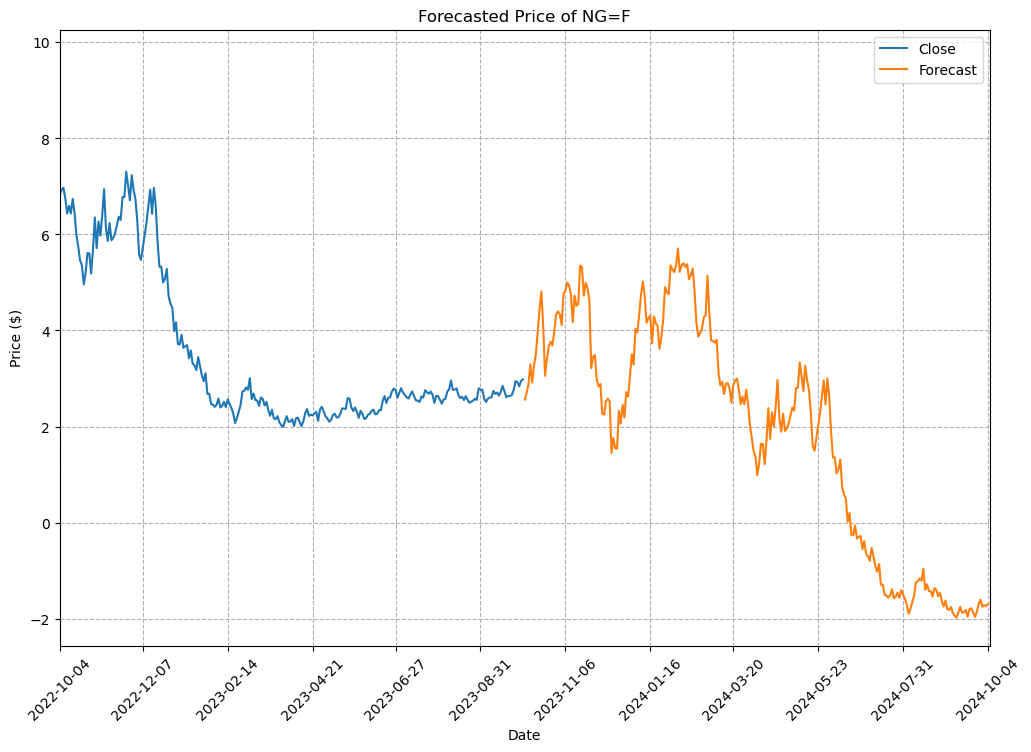

In [116]:
img = stock.plot_forecast()
img

Augmented Dicky-Fuller Test for First Difference
ADF Test Statistic : -10.177942650347111
p-value : 6.813759324051921e-18
# of lags : 22
Num of Observations Used : 2491
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


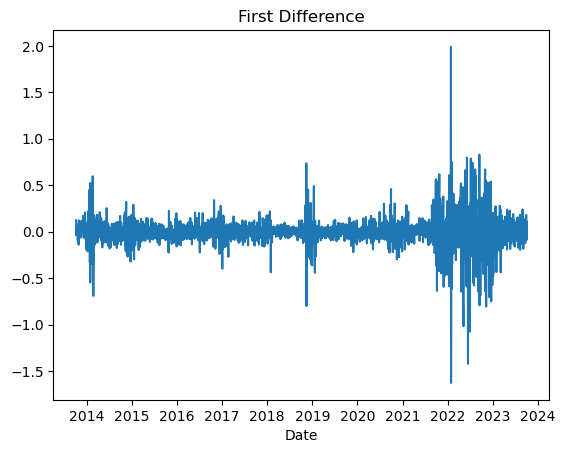

Augmented Dicky-Fuller Test for Second Difference
ADF Test Statistic : -16.894860427235752
p-value : 1.038369933959605e-29
# of lags : 23
Num of Observations Used : 2489
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


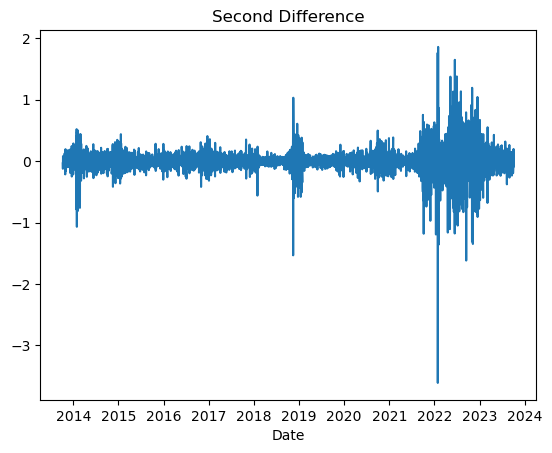

Augmented Dicky-Fuller Test for Seasonal Difference
ADF Test Statistic : -9.540109005228611
p-value : 2.741132946284034e-16
# of lags : 24
Num of Observations Used : 2460
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


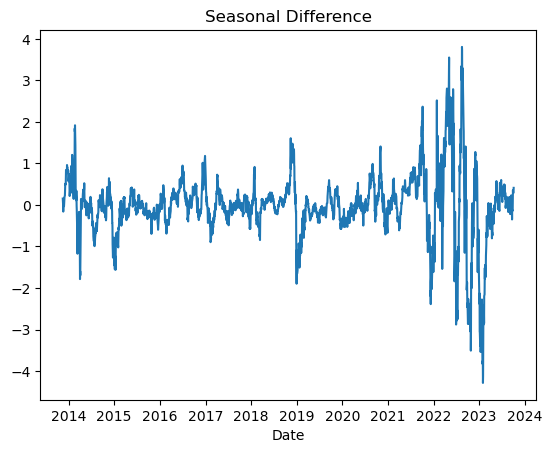

Augmented Dicky-Fuller Test for Seasonal First Difference
ADF Test Statistic : -10.448557444272344
p-value : 1.4583658861388207e-18
# of lags : 22
Num of Observations Used : 2461
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


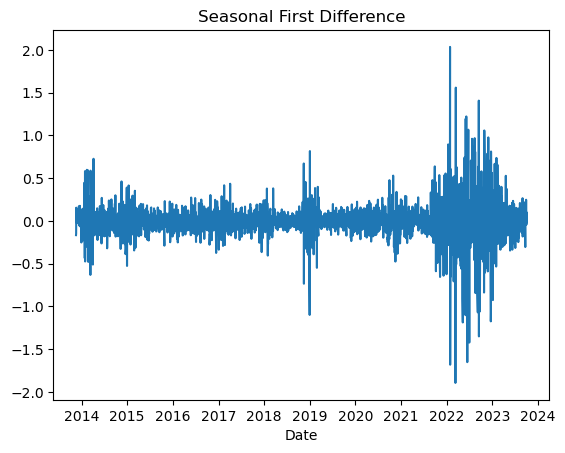

In [27]:
stock.plot_diff()

In [26]:
stock.summ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 2515
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 365)   Log Likelihood                 282.698
Date:                           Wed, 04 Oct 2023   AIC                           -563.397
Time:                                   00:50:04   BIC                           -557.724
Sample:                                        0   HQIC                          -561.322
                                          - 2515                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0450        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                  36.65   Jarque-Bera (JB):             19156.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.12   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.61
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

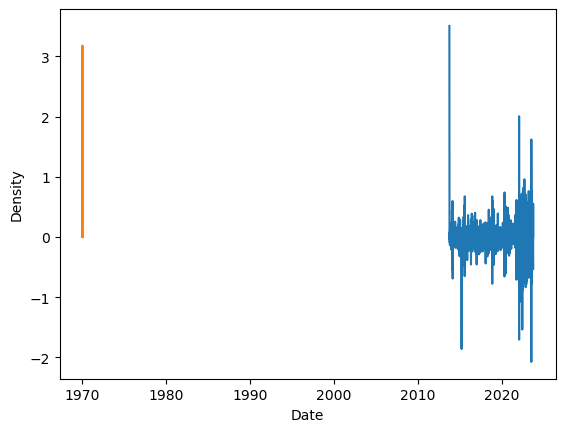

In [25]:
stock.plot_resid()

# Set Up

In [46]:
def setup(ticker, options: bool = False):
    # Get stock data
    stock = yf.Ticker(ticker).history(period="10y")
    
    # Reset index to index rather than date
    stock = stock.reset_index()
    
    # Create new df with only date and close
    df = stock[['Date', 'Close']]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
    df.set_index('Date', inplace=True)
    
    # Show descriptive statistics
    if options == True:
        df.describe().transpose()

    # Create time series
    time_series = df['Close']
    # type(time_series)
    
    if options == True:
        # Create rolling mean
        time_series.rolling(252).mean().plot(label='252 Day Rolling Mean')
        time_series.plot()
        
        # Create rolling std
        time_series.rolling(21).std().plot(label='21 Day Rolling STD')
        time_series.plot()
        
        plt.legend(['252 Day Rolling Mean', '21 Day Rolling STD'])
        plt.title('Time Series Analysis')
        
        # ETS Plot
        decomp = seasonal_decompose(time_series, period=12)
        decomp.plot()
        
    return df

/var/folders/qb/w57f6h956gz_cvz4j8x7qwdm0000gn/T/ipykernel_39571/5401417.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date


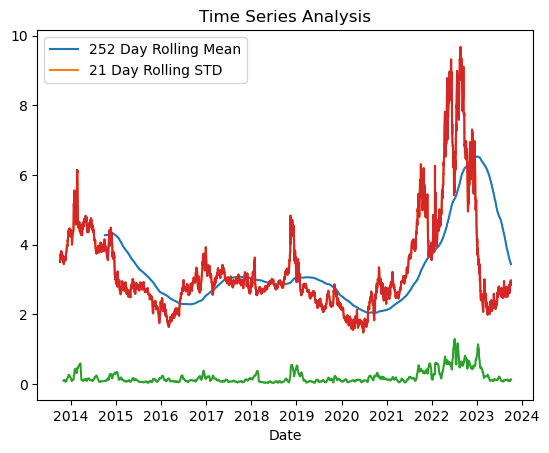

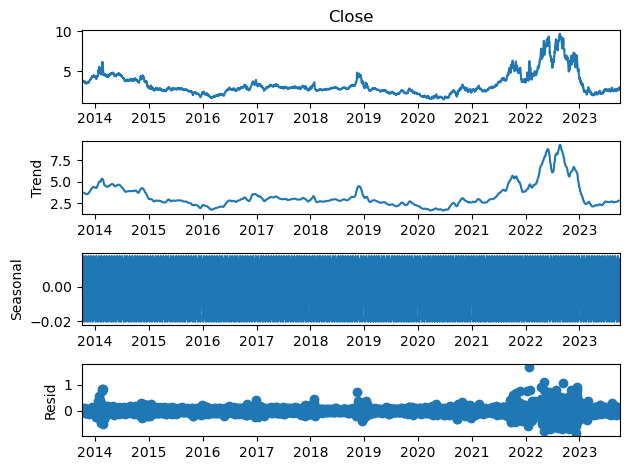

In [47]:
df = setup(ticker, options=True)

In [48]:
def adf_check(time_series):
    # Stationarity
    result = adfuller(time_series)
    
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Observations Used']

    for value, label in zip(result, labels):
        print(label+" : "+str(value))

    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis')
        print('reject null hypothesis')
        print('Data has no unit root and is stationary')

    else:
        print('Weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root and is non-stationary')

In [49]:
adf_check(df['Close'])

Augmented Dicky-Fuller Test
ADF Test Statistic : -2.635960142360973
p-value : 0.08579043095399458
# of lags : 23
Num of Observations Used : 2491
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and is non-stationary


# Differencing

In [50]:
def differencing(df, show: bool = False):
    if show == True:
        # Differencing: first difference, change from one period to the next
        df['First Difference'] = df['Close'] - df['Close'].shift(1)
        df['First Difference'].plot()
        plt.title('First Difference')
        plt.xlabel('Year')
        plt.show()
        
        # Run it through ADF
        # adf_check(df['First Difference'].dropna())  # need to first value since we don't have it anymore

        # Second
        df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
        # adf_check(df['Second Difference'].dropna())

        df['Second Difference'].plot()
        plt.title('Second Difference')
        plt.xlabel('Month')
        plt.show()
        
        # Seasonal
        df['Seasonal Difference'] = df['Close'] - df['Close'].shift(30)
        df['Seasonal Difference'].plot()
        plt.title('Seasonal Difference')
        plt.xlabel('Date')
        plt.show()

        # adf_check(df['Seasonal Difference'].dropna())
        
        # Seasonal First Difference
        df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(30)
        df['Seasonal First Difference'].plot()
        plt.title('Seasonal First Difference')
        plt.xlabel('Date')
        plt.show()

        adf_check(df['Seasonal First Difference'].dropna())
        
        return df
    
    if show == False:
        # Differencing: first difference, change from one period to the next
        df['First Difference'] = df['Close'] - df['Close'].shift(1)
        
        # Run it through ADF
        # adf_check(df['First Difference'].dropna())  # need to first value since we don't have it anymore

        # Second
        df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
        # adf_check(df['Second Difference'].dropna())
        
        # Seasonal
        df['Seasonal Difference'] = df['Close'] - df['Close'].shift(30)
        # adf_check(df['Seasonal Difference'].dropna())
        
        # Seasonal First Difference
        df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(30)
        adf_check(df['Seasonal First Difference'].dropna())
        
        return df       

In [51]:
differencing = differencing(df, show=False)

Augmented Dicky-Fuller Test
ADF Test Statistic : -10.448557444272344
p-value : 1.4583658861388207e-18
# of lags : 22
Num of Observations Used : 2461
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


# Autocorrelation

In [52]:
def autocorrelation(df):
    # Autocorrelation Plots
    fig_first = plot_acf(df['First Difference'].dropna())        
    fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna())

    autocorrelation_plot(df['Seasonal First Difference'].dropna())
    result = plot_pacf(df['Seasonal First Difference'].dropna())
    plot_pacf(df['Seasonal First Difference'].dropna())

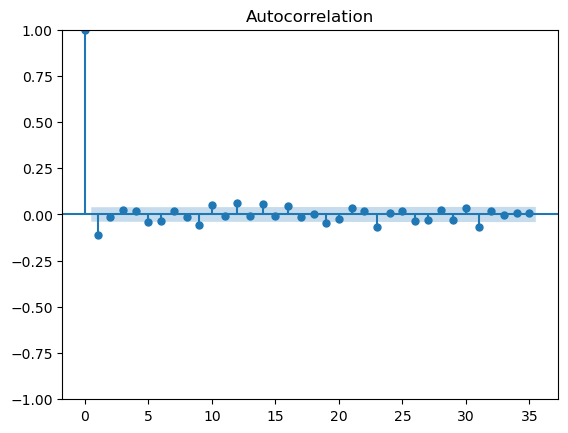

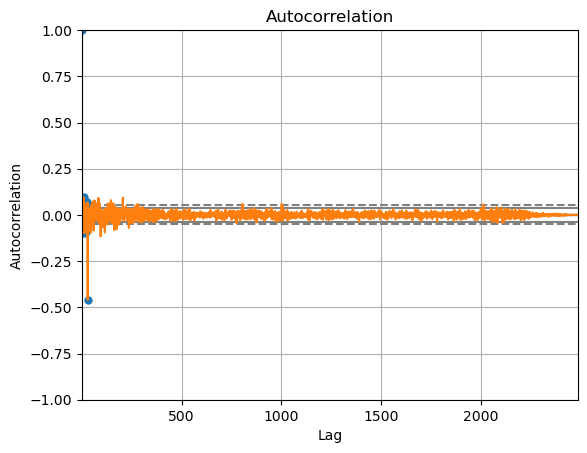

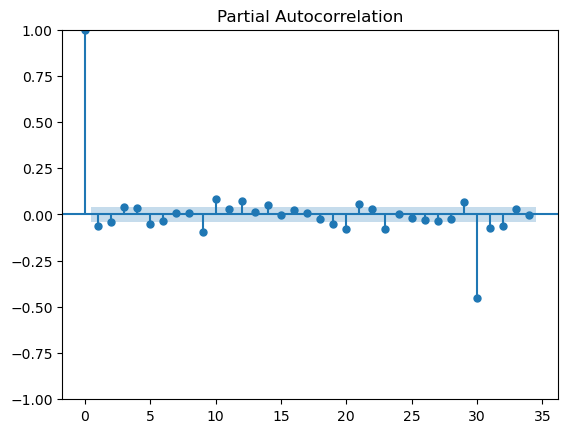

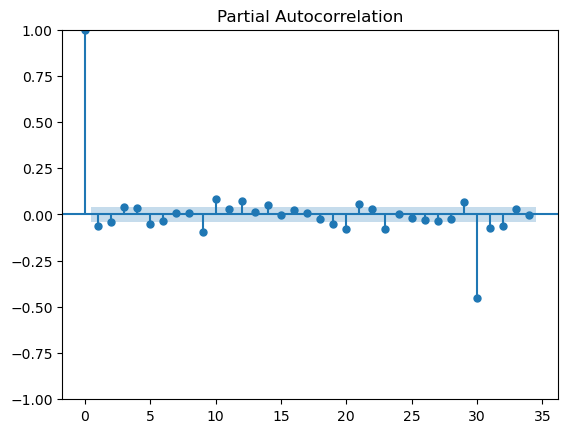

In [53]:
autocorrelation = autocorrelation(df)

order (p, d, q):
- p (Autoregressive Order): This parameter represents the number of autoregressive (AR) terms in the model. It indicates how many lag observations of the dependent variable should be included in the model.
- d (Integration Order): This parameter represents the order of differencing needed to make the time series stationary. It indicates how many times differencing should be applied to the series to achieve stationarity.
- q (Moving Average Order): This parameter represents the number of moving average (MA) terms in the model. It indicates how many lagged forecast errors should be included in the model.


seasonal_order (P, D, Q, S):
- P (Seasonal Autoregressive Order): This parameter represents the number of seasonal autoregressive (SAR) terms in the model. It is similar to p, but it applies to the seasonal component.
- D (Seasonal Integration Order): This parameter represents the order of seasonal differencing needed to make the seasonal part of the time series stationary.
- Q (Seasonal Moving Average Order): This parameter represents the number of seasonal moving average (SMA) terms in the model.
- S (Seasonal Periodicity): This parameter specifies the number of time steps in a seasonal cycle (e.g., 12 for monthly data, 4 for quarterly data).

In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable. This function uses Gaussian kernels and includes automatic bandwidth determination.

# Model

In [54]:
def model(df, show: bool = False, options: bool = False):
    # Need frequency for SARIMA model
    df.index.freq = 'D' # may or may not need
    
    # seasonal arima model
    model = sm.tsa.arima.ARIMA(df['Close'], order=(0, 1, 0), seasonal_order=(0, 1, 0, 365))
    
    # Fit model to see results
    results = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
    
    if options == True:
        results.summary()
    
    # Show plots and stats if true
    if show == True:
        results.resid.plot()
        results.resid.plot(kind='kde')
        
    return df, results
        

In [55]:
df, results = model(df, show=False, options=False)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method

In [56]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 2515
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 365)   Log Likelihood                 282.698
Date:                           Wed, 04 Oct 2023   AIC                           -563.397
Time:                                   12:19:34   BIC                           -557.724
Sample:                                        0   HQIC                          -561.322
                                          - 2515                                         
Covariance Type:                    Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0450        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                  36.65   Jarque-Bera (JB):             19156.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.12   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.61
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [66]:
summary_text = str(results.summary())
summary_text

'                                     SARIMAX Results                                     \n=========================================================================================\nDep. Variable:                             Close   No. Observations:                 2515\nModel:             ARIMA(0, 1, 0)x(0, 1, 0, 365)   Log Likelihood                 282.698\nDate:                           Wed, 04 Oct 2023   AIC                           -563.397\nTime:                                   12:26:45   BIC                           -557.724\nSample:                                        0   HQIC                          -561.322\n                                          - 2515                                         \nCovariance Type:                    Not computed                                         \n==============================================================================\n                 coef    std err          z      P>|z|      [0.025      0.975]\n--------------------

In [73]:
# Define regular expressions for the desired values
patterns = {
    'Model': r'Model:\s+(.*?)\s+Log',
    'Log Likelihood': r'Log Likelihood\s+(\S+)',
    'Date': r'Date:\s+(.*?)\s+AIC',
    'AIC': r'AIC\s+(\S+)',
    'Time': r'Time:\s+(\S+)\s+BIC',
    'BIC': r'BIC\s+(\S+)',
    'Sample': r'Sample:\s+(\S+)\s+HQIC',
    'HQIC': r'HQIC\s+(\S+)',
    'sigma2': r'sigma2\s+(\S+)',
    'Ljung-Box (L1) (Q)': r'Ljung-Box \(L1\) \(Q\):\s+(\S+)',
    'Jarque-Bera (JB)': r'Jarque-Bera \(JB\):\s+(\S+)',
    'Prob(Q)': r'Prob\(Q\):\s+(\S+)',
    'Heteroskedasticity (H)': r'Heteroskedasticity \(H\):\s+(\S+)',
    'Skew': r'Skew:\s+(\S+)',
    'Prob(H) (two-sided)': r'Prob\(H\) \(two-sided\):\s+(\S+)',
    'Kurtosis': r'Kurtosis:\s+(\S+)',
}

In [74]:
# Initialize a dictionary to store extracted values
extracted_data = {}

In [75]:
# Now, 'extracted_data' contains the extracted values
print(extracted_data)

{}


In [76]:
import re

In [77]:
# Iterate through the patterns and extract the data
for key, pattern in patterns.items():
    match = re.search(pattern, summary_text)
    if match:
        extracted_data[key] = match.group(1)

In [78]:
print(extracted_data)

{'Model': 'ARIMA(0, 1, 0)x(0, 1, 0, 365)', 'Log Likelihood': '282.698', 'Date': 'Wed, 04 Oct 2023', 'AIC': '-563.397', 'Time': '12:26:45', 'BIC': '-557.724', 'Sample': '0', 'HQIC': '-561.322', 'sigma2': '0.0450', 'Ljung-Box (L1) (Q)': '36.65', 'Jarque-Bera (JB)': '19156.67', 'Prob(Q)': '0.00', 'Heteroskedasticity (H)': '6.12', 'Skew': '-0.37', 'Prob(H) (two-sided)': '0.00', 'Kurtosis': '17.61'}


In [80]:
def summ_stats(self):
    summary = str(self.results.summary())
    
    # Define regular expressions for the desired values
    patterns = {
        'Model': r'Model:\s+(.*?)\s+Log',
        'Log Likelihood': r'Log Likelihood\s+(\S+)',
        'Date': r'Date:\s+(.*?)\s+AIC',
        'AIC': r'AIC\s+(\S+)',
        'Time': r'Time:\s+(\S+)\s+BIC',
        'BIC': r'BIC\s+(\S+)',
        'Sample': r'Sample:\s+(\S+)\s+HQIC',
        'HQIC': r'HQIC\s+(\S+)',
        'sigma2': r'sigma2\s+(\S+)',
        'Ljung-Box (L1) (Q)': r'Ljung-Box \(L1\) \(Q\):\s+(\S+)',
        'Jarque-Bera (JB)': r'Jarque-Bera \(JB\):\s+(\S+)',
        'Prob(Q)': r'Prob\(Q\):\s+(\S+)',
        'Heteroskedasticity (H)': r'Heteroskedasticity \(H\):\s+(\S+)',
        'Skew': r'Skew:\s+(\S+)',
        'Prob(H) (two-sided)': r'Prob\(H\) \(two-sided\):\s+(\S+)',
        'Kurtosis': r'Kurtosis:\s+(\S+)',
    }
    
    # Initialize a dictionary to store extracted values
    extracted_data = {}
    
    # Iterate through the patterns and extract the data
    for key, pattern in patterns.items():
        match = re.search(pattern, summary)
        if match:
            extracted_data[key] = match.group(1)
            
    return extracted_data

summ_stats()

{'Model': 'ARIMA(0, 1, 0)x(0, 1, 0, 365)',
 'Log Likelihood': '282.698',
 'Date': 'Wed, 04 Oct 2023',
 'AIC': '-563.397',
 'Time': '12:40:54',
 'BIC': '-557.724',
 'Sample': '0',
 'HQIC': '-561.322',
 'sigma2': '0.0450',
 'Ljung-Box (L1) (Q)': '36.65',
 'Jarque-Bera (JB)': '19156.67',
 'Prob(Q)': '0.00',
 'Heteroskedasticity (H)': '6.12',
 'Skew': '-0.37',
 'Prob(H) (two-sided)': '0.00',
 'Kurtosis': '17.61'}

# Forecast

In [93]:
def forecast(df, results):
    # Reset the index of df
    df.reset_index(drop=False, inplace=True)
    
    # Forecast Length
    start = len(df)
    end = round(len(df) + 252)  # TODO: Make dynamic
    
    # Forecasting Current
    df['forecast'] = results.predict(start=start, end=end)
    
    # Forecast future values, create and add time periods to do so
    start_date = df['Date'].max()
    # Create a CustomBusinessDay object to exclude weekends and holidays
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    # Create future dates
    future_dates = pd.date_range(start_date, periods=252, freq=us_bd).strftime('%Y-%m-%d')  # TODO: Make dynamic period
    
    df.set_index('Date', inplace=True)

    # Create a future dates df
    future_df = pd.DataFrame(index=future_dates, columns=df.columns)
    future_df.index.name = 'Date'
    
    # Concatenate the original df with the future_df
    final_df = pd.concat([df, future_df])
    final_df.index.name = 'Date'
    
    final_df.reset_index(inplace=True)
    
    final_df['forecast'] = results.predict(start=start, end=end)
    
    return final_df

In [94]:
final_df = forecast(df, results)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [96]:
def plot_forecast(final_df, ticker):
    # Plot
    final_df[['Close', 'forecast']].plot(figsize=(12, 8))

    # # X limit
    plt.xlim((len(df) - 252), len(final_df))

    # Add a grid with dotted lines
    plt.grid(linestyle='--')

    # Choose the number of evenly spaced ticks you want (e.g., 12)
    num_ticks = 12

    # Calculate tick positions
    tick_positions = np.linspace((len(df) - 252), (len(final_df) - 1), num_ticks, dtype=int)

    # Get the corresponding dates for the tick positions
    tick_labels = final_df.index[tick_positions]

    # Set the ticks and labels
    plt.xticks(tick_positions, tick_labels, rotation=45)  # Rotate labels for better visibility

    # Labels
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'Forecasted Price of {ticker}')
    plt.show()

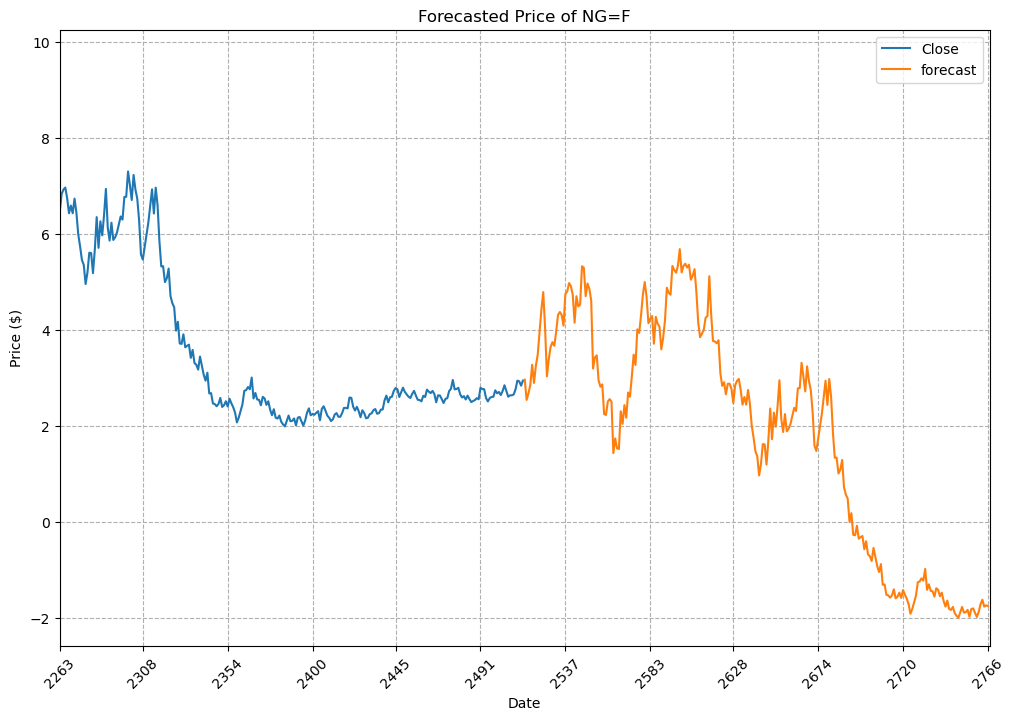

In [98]:
plot_forecast(final_df, ticker)

# Testing

In [149]:
ticker = 'NG=F'
arima = Arima(ticker, show=False, options=False)

/var/folders/qb/w57f6h956gz_cvz4j8x7qwdm0000gn/T/ipykernel_96108/3887599047.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python

In [154]:
arima

In [155]:
data = pd.DataFrame(arima)

ValueError: DataFrame constructor not properly called!

In [ ]:
d